# import the necessary packages


In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D ,  MaxPooling2D ,Flatten , Dense , Dropout , BatchNormalization
from tensorflow.keras.activations import relu , sigmoid 
from sklearn.model_selection import train_test_split


# Function to load the image

In [68]:
# Function to load images from a folder and return as a numpy array
def load_images_from_folder(folder, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=image_size)  # Load image and resize
            img_array = img_to_array(img) / 255.0  # Convert to numpy array and normalize
            images.append(img_array)
            labels.append(label)
    return images, labels


# Data path

In [24]:
# Paths to the two folders containing the images
without_mask_path = 'D:\\New folder (9)\\final project\\Face-Mask-Detection-master\\dataset\\without_mask'
with_mask_path = 'D:\\New folder (9)\\final project\\Face-Mask-Detection-master\\dataset\\with_mask'

# Load the image and labels

In [25]:
# Load images and labels for both categories
without_mask_images, without_mask_labels = load_images_from_folder(without_mask_path, 0)  # 0 for 'without mask'
with_mask_images, with_mask_labels = load_images_from_folder(with_mask_path, 1)  # 1 for 'with mask'

# Combine the images

In [26]:
# Combine images and labels
all_images = np.array(without_mask_images + with_mask_images)
all_labels = np.array(without_mask_labels + with_mask_labels)

# Split the data

In [69]:
# Split data into training and validation sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)


In [28]:
# Check shapes of data
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')


Train images shape: (3066, 224, 224, 3)
Train labels shape: (3066,)
Validation images shape: (767, 224, 224, 3)
Validation labels shape: (767,)


# Preprocessing the data

## Data Augmentation

In [70]:
# Preprocessing with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values to [0, 1]
    rotation_range=40,             # Random rotation
    width_shift_range=0.2,         # Random horizontal shift
    height_shift_range=0.2,        # Random vertical shift
    shear_range=0.2,               # Shearing transformation
    zoom_range=0.2,                # Zoom in or out
    horizontal_flip=True,          # Random horizontal flip
    fill_mode='nearest'            # Fill mode for newly created pixels during transformations
)

# Rescale the validation data

In [71]:
# Validation data should only be rescaled (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)


In [72]:
# Apply the data augmentation to the training images and rescaling to both training and validation images
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)


# Build the model (Cnn)

In [57]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Conv2D(32, (3,3) , activation='relu' ,input_shape=(224, 224, 3) , kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(64 ,(3,3) , activation='relu' , kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    Conv2D(200, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

# Model Compilation

In [58]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer = optimizer , loss='binary_crossentropy' ,  metrics = ['accuracy'])

# Model summary

In [59]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 200)    │       230,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 200)    │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,012,201 (15.31 MB)

 Trainable params: 4,011,353 (15.30 MB)

 Non-trainable params: 848 (3.31 KB)

# Model Checkpoint

In [73]:
checkpoint = ModelCheckpoint(
    'mask_detection_best3_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping

In [61]:
 #Define EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Monitor validation loss
    patience=3,                # Stop after 3 epochs of no improvement
    mode='max',               # We want to maximize accuracy
    restore_best_weights=True,  # Restore best weights
    verbose=1

)

# Model training

In [62]:
# Train the model using the loaded images and labels directly
history = model.fit(
    train_images,             # Training images as numpy array
    train_labels,             # Training labels as numpy array
    batch_size=32,            # Batch size
    epochs=15,                # Number of epochs
    validation_data=(val_images, val_labels),  # Validation data as numpy arrays
    callbacks=[checkpoint, early_stopping],  # Callbacks
    shuffle=True              # Shuffle the data at the start of each epoch
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8233 - loss: 5.5988
Epoch 1: val_accuracy improved from -inf to 0.53977, saving model to mask_detection_best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8238 - loss: 5.5837 - val_accuracy: 0.5398 - val_loss: 3.6528
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9234 - loss: 2.4619
Epoch 2: val_accuracy did not improve from 0.53977
96/96 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9234 - loss: 2.4595 - val_accuracy: 0.5306 - val_loss: 5.7965
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9246 - loss: 1.6883
Epoch 3: val_accuracy did not improve from 0.53977
96/96 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9246 - loss: 1.6871 - val_accuracy: 0.5306 - val_loss: 3.3601
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9240 - loss: 1.3284
Epoch 4: val_accuracy improved from 0.53977 to 0.89700, saving model to mask_detection_best_model.keras
96/96 ━━━━━━━

# Evaluate the model

In [63]:
from tensorflow.keras.models import load_model
best_model = load_model('mask_detection_best_model.keras')

In [64]:
# Evaluate the model on the training data using numpy arrays
loss, accuracy = model.evaluate(
    train_images, 
    train_labels,
    batch_size=32
)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.9166 - loss: 1.3220
Loss: 1.2961840629577637
Accuracy :0.9220482707023621


In [74]:
# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(
    val_images, val_labels,   # Use the same validation data as numpy arrays
    batch_size=32             
)

print(f'Validation Loss of Best Model: {val_loss}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.9194 - loss: 1.3997
Validation Loss of Best Model: 1.3385485410690308


# Make the Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


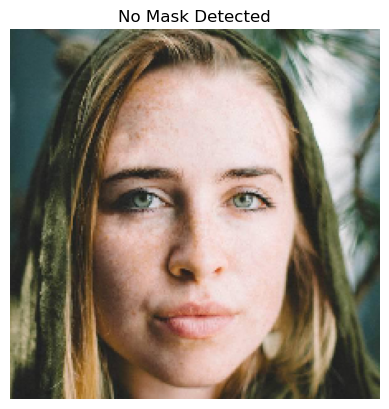

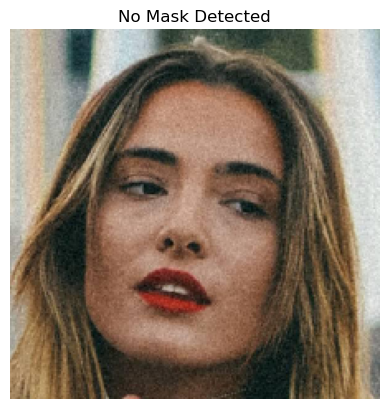

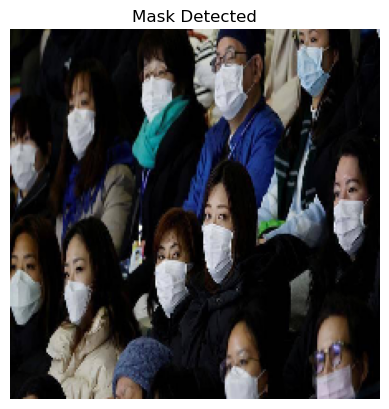

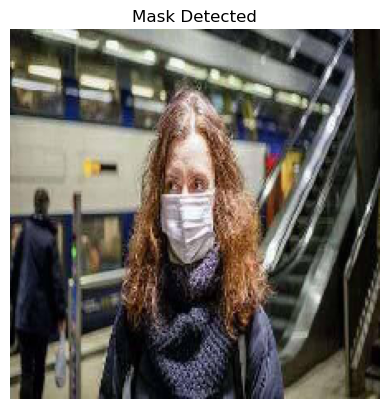

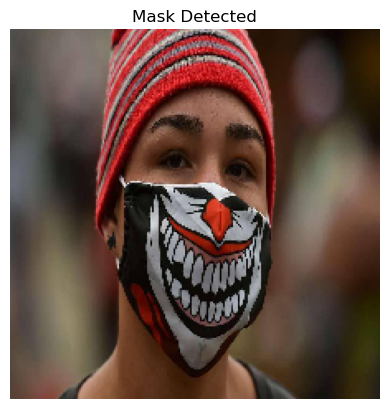

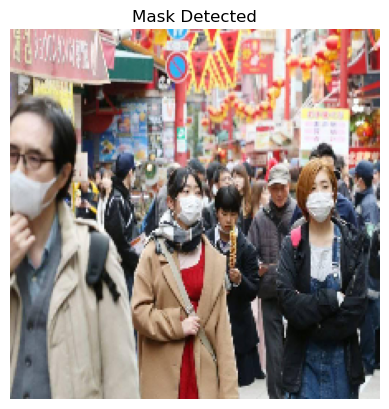

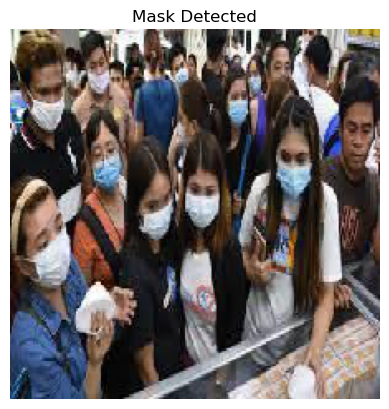

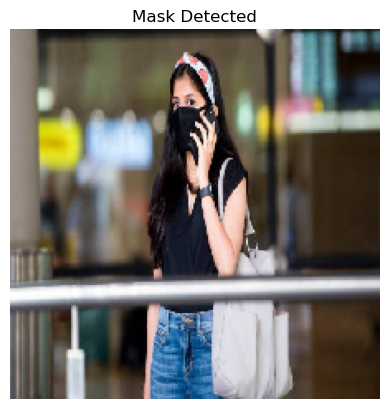

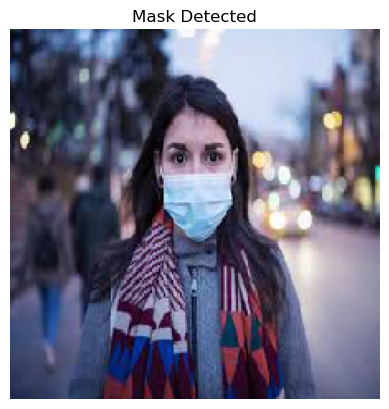

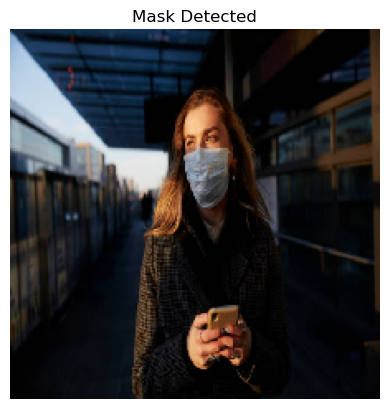

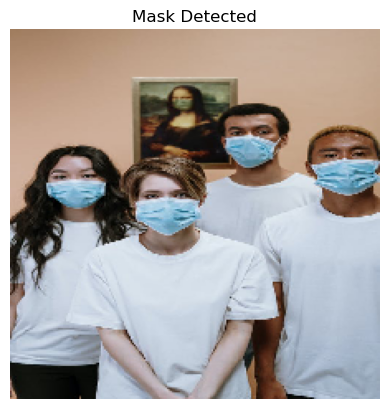

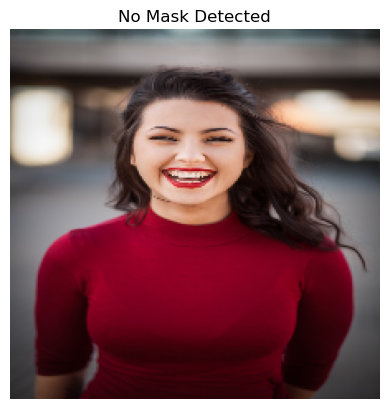

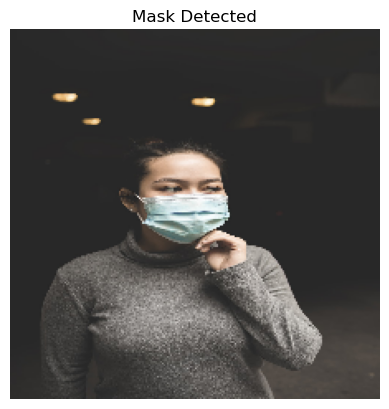

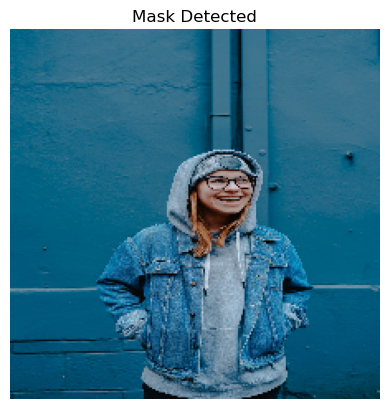

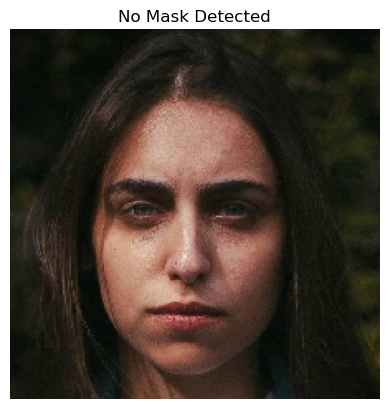

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the folder containing test images
test_image_folder = 'D:\\New folder (9)\\computer vision project\\test'

# Function to load and preprocess images from the test folder
def load_and_preprocess_images(test_image_folder, target_size=(224, 224)):
    img_list = []
    img_paths = []
    
    # Loop over the files in the test folder
    for filename in os.listdir(test_image_folder):
        img_path = os.path.join(test_image_folder, filename)
        
        # Check if it's a valid file
        if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = image.load_img(img_path, target_size=target_size)  # Load and resize image
            img_array = image.img_to_array(img)  # Convert to numpy array
            img_array = img_array / 255.0  # Normalize the image
            img_list.append(img_array)
            img_paths.append(img_path)
    
    # Stack the images into a single numpy array for batch prediction
    return np.array(img_list), img_paths

# Load and preprocess test images
test_images, test_image_paths = load_and_preprocess_images(test_image_folder)

# Make predictions for the batch of images
predictions = model.predict(test_images)

# Display each image with the corresponding prediction
for i, img_path in enumerate(test_image_paths):
    img = image.load_img(img_path, target_size=(224, 224))  # Reload the image for displaying
    
    # Show the image
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    
    # Prediction
    if predictions[i] > 0.5:
        prediction_text = "Mask Detected"
    else:
        prediction_text = "No Mask Detected"
    
    # Show prediction text
    plt.title(prediction_text)
    plt.show()
